In [4]:
# Install dependencies
%pip install optlang

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.1 MB/s eta 0:00:00


In [5]:
# Install dependencies
%pip install pandas matplotlib numpy

In [6]:
from optlang import Model, Variable, Constraint, Objective

In [7]:
import numpy as np
import pandas as pd

# Draw a network diagram. Show each month as a node, and the investments, receipts and expenditures as arcs.**

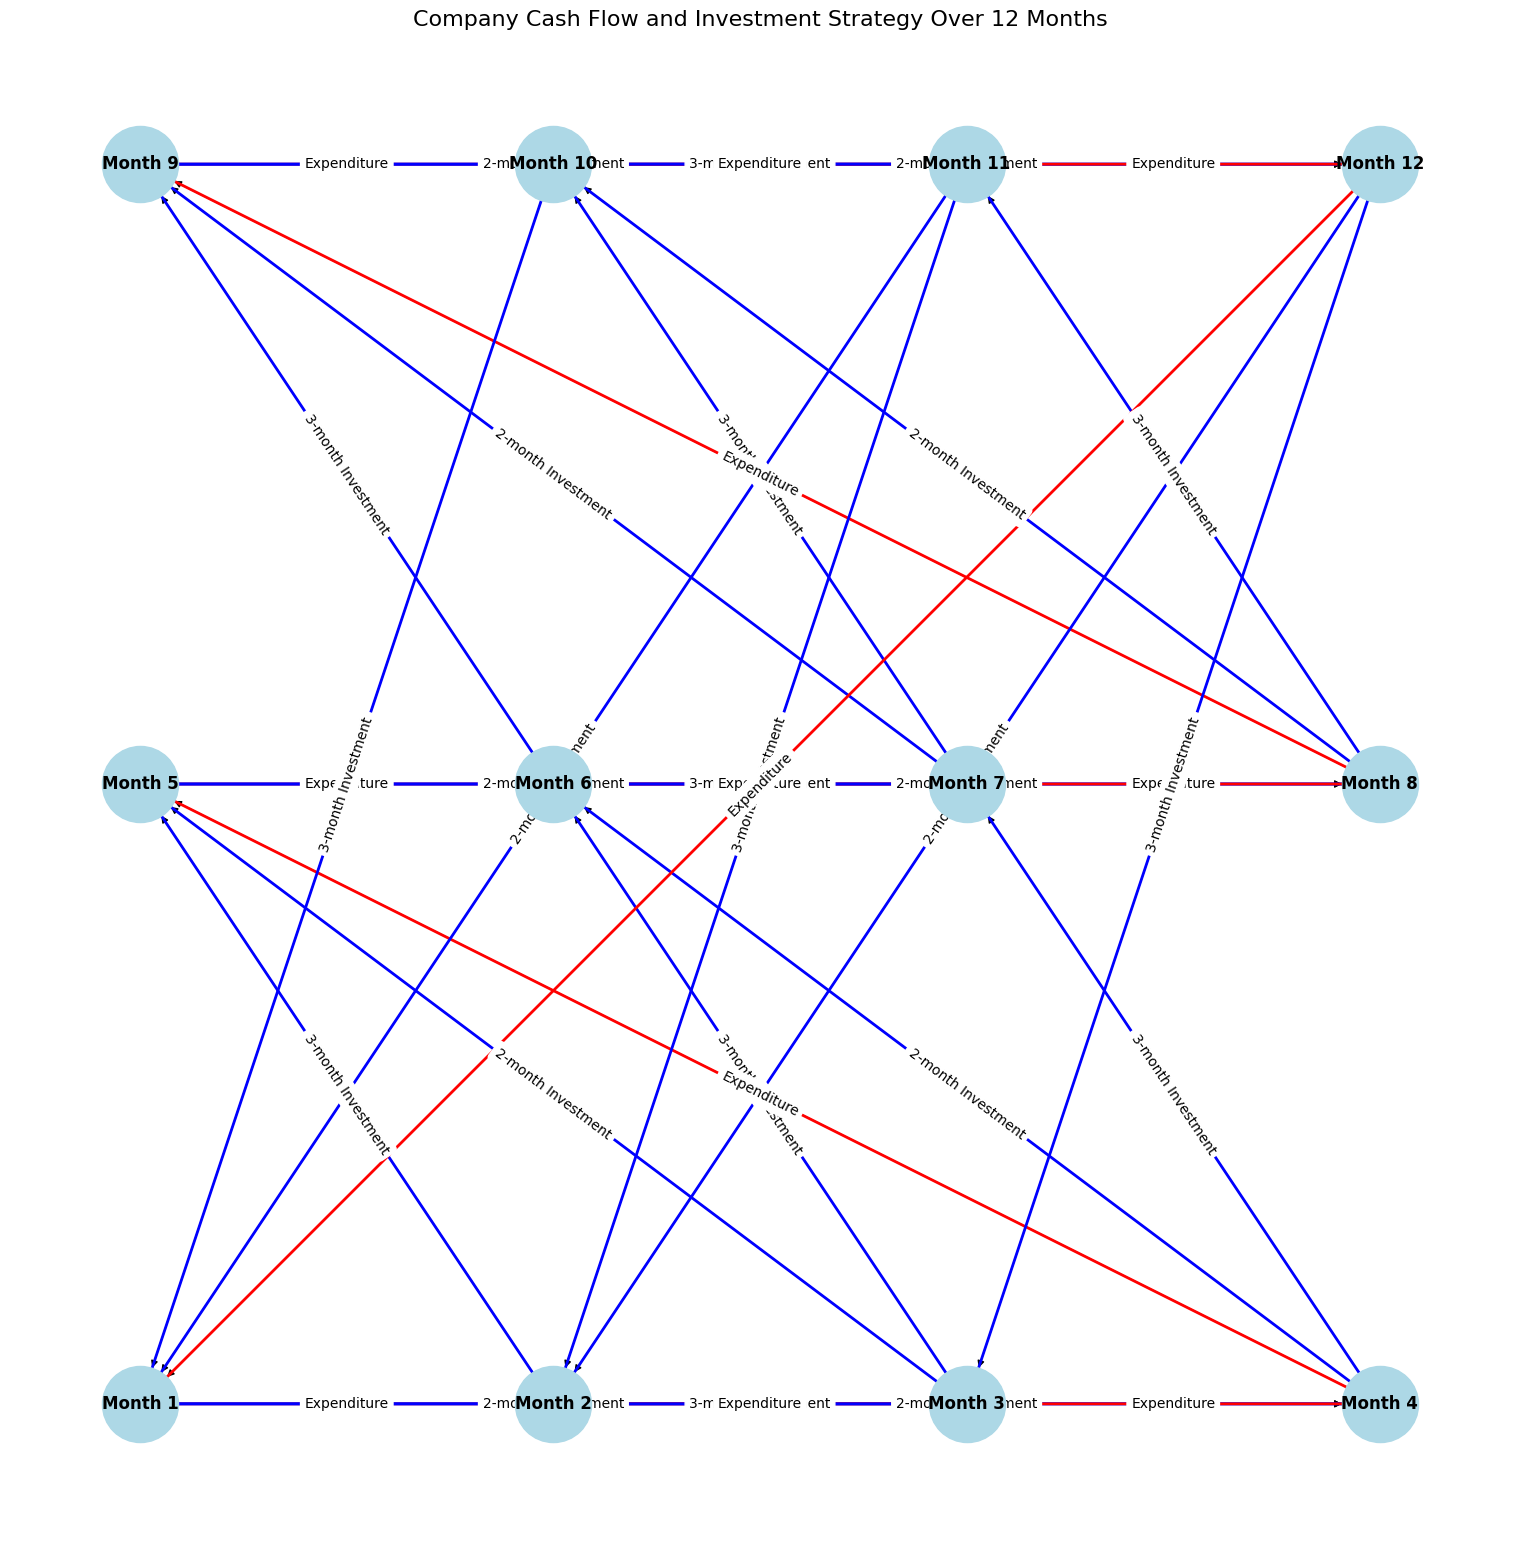

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each month
months = [f"Month {i}" for i in range(1, 13)]
G.add_nodes_from(months)

# Define relationships between nodes for receipts, expenditures, and investments
for i in range(12):
    current_month = f"Month {i+1}"

    # Add arcs for investments, receipts, and expenditures
    # The weights here are placeholders and should be adjusted according to actual financial data
    for j in range(1, 4):  # Connect each month to the next three months
        next_month = f"Month {(i+j) % 12 + 1}"  # Wrap around to Month 1 after Month 12
        G.add_edge(current_month, next_month, transaction=f'{j}-month Investment', weight=2, color='blue')

    # Receipts and expenditures are only connected to the next month
    next_month = f"Month {(i+1) % 12 + 1}"
    G.add_edge(current_month, next_month, transaction='Receipt', weight=2, color='green')
    G.add_edge(current_month, next_month, transaction='Expenditure', weight=2, color='red')

# Create a grid layout
grid_side = int(np.ceil(np.sqrt(len(months))))
pos = {f"Month {i+1}": (i % grid_side, i // grid_side) for i in range(len(months))}

# Increase the size of the plot
plt.figure(figsize=(15, 15))

# Draw the network
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=12, font_weight='bold')

# Customizing the edges based on the attributes like color
edges = G.edges(data=True)
colors = [edge[2]['color'] for edge in edges]
weights = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='-|>', arrowsize=20, edge_color=colors, width=weights)

# Draw labels on the edges
edge_labels = dict([((u, v,), d['transaction'])
                    for u, v, d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10)

# Show the plot
plt.title('Company Cash Flow and Investment Strategy Over 12 Months', fontsize=16)
plt.axis('off')  # Turn off the axis
plt.show()


This is a network diagram to represent the company’s cash flow and investment strategy over a 12-month period. Here’s the components of the digram:

- **Nodes**: Each node in the graph represents a month. The code creates 12 nodes, one for each month of the year.
- **Arcs**:
  - From each node (month), there are three outgoing arcs representing possible investments in 1-month, 2-month, and 3-month CDs.
  - There are incoming arcs to each node from the previous months representing maturing CDs.
  - Each node also has an incoming arc and an outgoing arc representing the receipt and expense for the month, respectively.

This diagram serves as a visual aid to understand the temporal flow of money and investments. It helps the company to manage its cash flow and determine the best investment strategy subject to cash requirements

# Formulate the relevant optimization problem as an optlang model, using node and arc declarations.**

In this model, we can define sets, parameters, variables, constraints, and the objective function. In this case, we can define the following:

**Sets:**
- `MONTHS`: This set represents the 12 months in a year. Each month is represented by an integer from 1 to 12.
- `TERMS`: This set represents the different investment terms available to the company. In this case, the company can invest in 1-month, 2-month, or 3-month certificates of deposit (CDs).

**Parameters:**
- `receipts{MONTHS}`: This parameter represents the estimated cash receipts for each month. It is defined for each month in the MONTHS set and must be non-negative.
- `expenditures{MONTHS}`: This parameter represents the estimated cash expenditures for each month. It is defined for each month in the MONTHS set and must be non-negative.
- `returns{MONTHS, TERMS}`: This parameter represents the returns on the different CDs for each month. It is defined for each month and each investment term and must be non-negative.

**Variables:**
- `Investment{MONTHS, TERMS}`: This variable represents the amount of money to invest in each type of CD for each month. It is defined for each month and each investment term and must be non-negative.

**Constraints:**

- `Cash_Flow{i in MONTHS}`: This constraint ensures that the cash flow (receipts plus returns from matured investments minus expenditures and new investments) is non-negative for each month.

**Objective function:**
- `Total_Return`: This is the objective function of the model, which is to maximize the total return from the investments over the 12 months.

In [3]:
%%writefile model.mod

# Sets
set MONTHS := 1..12;
set TERMS := {'1-month', '2-month', '3-month'};

# Parameters
param receipts{MONTHS} >= 0;
param expenditures{MONTHS} >= 0;
param returns{MONTHS, TERMS} >= 0;

# Variables
var Investment{MONTHS, TERMS} >= 0;

# Constraints
subject to Cash_Flow{i in MONTHS}:
    sum{j in TERMS} Investment[i,j] + expenditures[i] <= receipts[i] + sum{j in TERMS: i-j >= 1} Investment[i-j,j] * (1 + returns[i-j,j]);

# Objective function
maximize Total_Return: sum{i in MONTHS, j in TERMS} Investment[i,j] * returns[i,j];

# Data
data;

param receipts := ... ;
param expenditures := ... ;
param returns := ... ;

# Solve
solve;

Writing model.mod


In [11]:
# Python Optlang Model for Company Cash Flow and Investment Strategy

import numpy as np
from optlang import Model, Variable, Constraint, Objective

# Sets and Parameters
months = list(range(1, 13))
investments = ['1-month', '2-month', '3-month']

# Placeholder data for receipts, expenditures, and returns
receipts = {month: 1000 for month in months}  # Cash receipts for each month
expenditures = {month: 500 for month in months}  # Cash expenditures for each month
returns = {investment: 0.02 for investment in investments}  # Returns on different certificates

# Decision Variables
Invest = {month: {investment: Variable(f"Invest_{month}_{investment}", lb=0) for investment in investments} for month in months}

# Objective Function
# Maximize the total return from investments over the 12 months
total_return = sum(returns[investment] * Invest[month][investment] for month in months for investment in investments)
objective = Objective(total_return, direction='max')

# Constraints
constraints = []
for month in months:
    # Cash on hand at the start of the month
    cash_on_hand = sum(Invest[month_prev][investment] for month_prev in months for investment in investments if month_prev < month)
    # Plus receipts
    cash_on_hand += receipts[month]
    # Minus expenditures
    cash_on_hand -= expenditures[month]
    # Minus investments
    cash_on_hand -= sum(Invest[month][investment] for investment in investments)
    # Must be greater than or equal to zero
    constraints.append(Constraint(cash_on_hand, lb=0))

# Create the model
model = Model(name='Company_Cash_Flow_and_Investment_Strategy')
model.objective = objective
model.add(constraints)

# Solve the problem
model.optimize()

# Display the solution
for month in months:
    for investment in investments:
        print(f"Investment in {investment} in Month {month}: {Invest[month][investment].primal}")


Investment in 1-month in Month 1: 500.0
Investment in 2-month in Month 1: 0.0
Investment in 3-month in Month 1: 0.0
Investment in 1-month in Month 2: 1000.0
Investment in 2-month in Month 2: 0.0
Investment in 3-month in Month 2: 0.0
Investment in 1-month in Month 3: 2000.0
Investment in 2-month in Month 3: 0.0
Investment in 3-month in Month 3: 0.0
Investment in 1-month in Month 4: 4000.0
Investment in 2-month in Month 4: 0.0
Investment in 3-month in Month 4: 0.0
Investment in 1-month in Month 5: 8000.0
Investment in 2-month in Month 5: 0.0
Investment in 3-month in Month 5: 0.0
Investment in 1-month in Month 6: 16000.0
Investment in 2-month in Month 6: 0.0
Investment in 3-month in Month 6: 0.0
Investment in 1-month in Month 7: 32000.0
Investment in 2-month in Month 7: 0.0
Investment in 3-month in Month 7: 0.0
Investment in 1-month in Month 8: 64000.0
Investment in 2-month in Month 8: 0.0
Investment in 3-month in Month 8: 0.0
Investment in 1-month in Month 9: 128000.0
Investment in 2-mon

# Construct an appropriate data file, and solve the resulting linear program**

In [1]:
from IPython.display import display, Math

# Cash Flow Continuity


\begin{equation}
\text{Receipts}_t + \sum_{d \leq t} \sum_{b} x_{t-d,b,d} \cdot (1 + r_{t-d,b,d}) - \text{Expenses}_t - \sum_{b}\sum_{d} x_{t,b,d} \geq 0 \quad \forall t
\end{equation}
This ensures that the cash on hand plus matured investments are sufficient to cover expenses and new investments.


# Bank Investment Limits

\begin{equation}
\sum_{d} x_{t,b,d} \leq 0.7 \cdot (\text{Receipts}_t + \text{Expenses}_t) \quad \forall t, \forall b
\end{equation}
This prevents investing more than 70\% of total available cash in any single bank.


# Objective Function

\begin{equation}
\max \sum_{t} \sum_{b} \sum_{d} x_{t,b,d} \cdot r_{t,b,d}
\end{equation}
where r_{t,b,d} is the rate of return for investments made at bank b, in month t, for duration d.

In [21]:
from optlang import Model, Variable, Constraint, Objective
import pandas as pd

# Define the data
receipts_expenses = pd.DataFrame ({
    'Month': range(1, 13),
    'Receipt': [3200, 3600, 3100, 1000, 1000, 1000, 1200, 1200, 1200, 1500, 1800, 1900],
    'Expense': [200, 200, 400, 800, 2100, 4500, 3300, 1800, 600, 200, 200, 200]
}).set_index('Month')

rates_of_return = pd.DataFrame({
    'Month': range(1, 13),
    'CIT1': [0.00433, 0.00437, 0.00442, 0.00446, 0.00450, 0.00458, 0.00467, 0.00487, 0.00500, 0.00500, 0.00492, 0.00483],
    'CIT2': [0.01067, 0.01075, 0.01083, 0.01092, 0.01100, 0.01125, 0.01142, 0.01183, 0.01217, 0.01217, 0.01217, 0.01217],
    'CIT3': [0.01988, 0.02000, 0.02013, 0.02038, 0.02050, 0.02088, 0.02113, 0.02087, 0.02237, 0.02250, 0.02250, 0.02275],
    'NBD1': [0.00425, 0.00429, 0.00433, 0.00437, 0.00442, 0.00450, 0.00458, 0.00479, 0.00492, 0.00492, 0.00483, 0.00475],
    'NBD2': [0.01067, 0.01075, 0.01083, 0.01092, 0.01100, 0.01125, 0.01142, 0.01183, 0.01217, 0.01217, 0.01233, 0.01250],
    'NBD3': [0.02013, 0.02025, 0.02063, 0.02088, 0.02100, 0.02138, 0.02162, 0.02212, 0.02262, 0.02275, 0.02275, 0.02312]
}).set_index('Month')

In [22]:
receipts_expenses

,Receipt,Expense
Month,,
1,3200,200
2,3600,200
3,3100,400
4,1000,800
5,1000,2100
6,1000,4500
7,1200,3300
8,1200,1800
9,1200,600


In [23]:
rates_of_return

,CIT1,CIT2,CIT3,NBD1,NBD2,NBD3
Month,,,,,,
1,0.00433,0.01067,0.01988,0.00425,0.01067,0.02013
2,0.00437,0.01075,0.02000,0.00429,0.01075,0.02025
3,0.00442,0.01083,0.02013,0.00433,0.01083,0.02063
4,0.00446,0.01092,0.02038,0.00437,0.01092,0.02088
5,0.00450,0.01100,0.02050,0.00442,0.01100,0.02100
6,0.00458,0.01125,0.02088,0.00450,0.01125,0.02138
7,0.00467,0.01142,0.02113,0.00458,0.01142,0.02162
8,0.00487,0.01183,0.02087,0.00479,0.01183,0.02212
9,0.00500,0.01217,0.02237,0.00492,0.01217,0.02262


In [34]:
# Create a model
model = Model(name='Investment Strategy Optimization')

# Create variables for the investments in each type of CD for each month
investments = pd.DataFrame({
    'CIT1': [Variable(f'Investment_{i}_CIT1', lb=0) for i in range(1, 13)],
    'CIT2': [Variable(f'Investment_{i}_CIT2', lb=0) for i in range(1, 13)],
    'CIT3': [Variable(f'Investment_{i}_CIT3', lb=0) for i in range(1, 13)],
    'NBD1': [Variable(f'Investment_{i}_NBD1', lb=0) for i in range(1, 13)],
    'NBD2': [Variable(f'Investment_{i}_NBD2', lb=0) for i in range(1, 13)],
    'NBD3': [Variable(f'Investment_{i}_NBD3', lb=0) for i in range(1, 13)]
}, index=range(1, 13))

# Add the investment variables to the model
for month in investments.index:
    for term in investments.columns:
        model.add(investments.loc[month, term])

# Create constraints for the cash flow for each month
for i in range(1, 13):
    model.add(Constraint(
        sum(investments.loc[i, term] for term in investments.columns) + receipts_expenses.loc[i, 'Expense'] - receipts_expenses.loc[i, 'Receipt'] - sum(investments.loc[i-j if i-j > 0 else None, term] * (1 + rates_of_return.loc[i-j if i-j > 0 else None, term]) for j in range(1, 4) for term in ['CIT'+str(j), 'NBD'+str(j)] if term in investments.columns and i-j > 0),
        ub=0,
        name=f'Cash_Flow_{i}'
    ))

# Create the objective function
model.objective = Objective(
    sum(investments.loc[i, term] * rates_of_return.loc[i, term] for i in range(1, 13) for term in investments.columns),
    direction='max'
)

# Solve the problem
model.optimize()

# Display the solution
for month in range(1, 13):
    for term in investments.columns:
        print(f"Investment in {term} in Month {month}: {investments.loc[month, term].primal}")

Investment in CIT1 in Month 1: 0.0
Investment in CIT2 in Month 1: 1179.59591363322
Investment in CIT3 in Month 1: 0.0
Investment in NBD1 in Month 1: 0.0
Investment in NBD2 in Month 1: 0.0
Investment in NBD3 in Month 1: 1820.40408636678
Investment in CIT1 in Month 2: 1745.8376302979266
Investment in CIT2 in Month 2: 0.0
Investment in CIT3 in Month 2: 0.0
Investment in NBD1 in Month 2: 0.0
Investment in NBD2 in Month 2: 0.0
Investment in NBD3 in Month 2: 1654.1623697020736
Investment in CIT1 in Month 3: 0.0
Investment in CIT2 in Month 3: 0.0
Investment in CIT3 in Month 3: 0.0
Investment in NBD1 in Month 3: 0.0
Investment in NBD2 in Month 3: 0.0
Investment in NBD3 in Month 3: 5645.649142774015
Investment in CIT1 in Month 4: 0.0
Investment in CIT2 in Month 4: 0.0
Investment in CIT3 in Month 4: 0.0
Investment in NBD1 in Month 4: 0.0
Investment in NBD2 in Month 4: 0.0
Investment in NBD3 in Month 4: 2057.048820625343
Investment in CIT1 in Month 5: 0.0
Investment in CIT2 in Month 5: 0.0
Invest

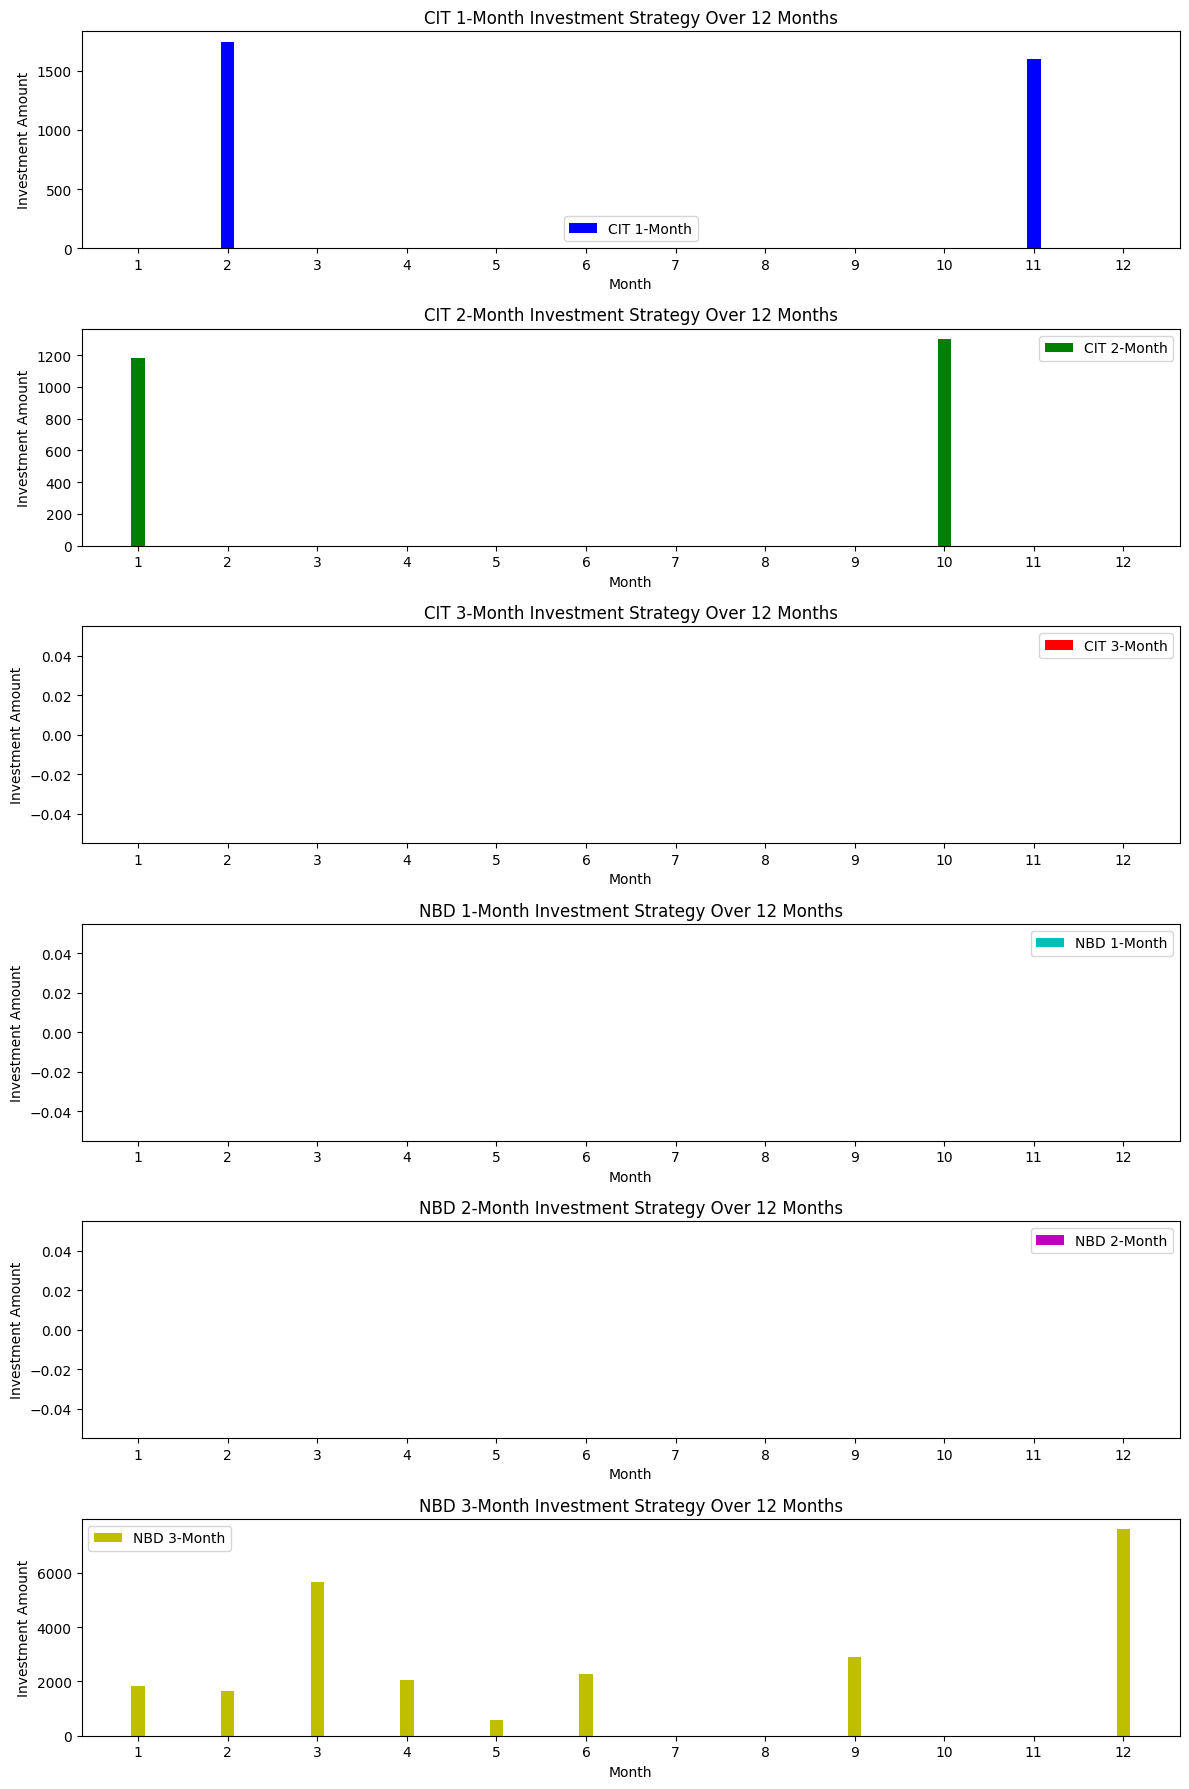

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Create lists for the months and investment amounts
months = list(range(1, 13))

# Get the investment amounts from the optimization results
CIT_investments_1M = [investments.loc[month, 'CIT1'].primal for month in months]
CIT_investments_2M = [investments.loc[month, 'CIT2'].primal for month in months]
CIT_investments_3M = [investments.loc[month, 'CIT3'].primal for month in months]
NBD_investments_1M = [investments.loc[month, 'NBD1'].primal for month in months]
NBD_investments_2M = [investments.loc[month, 'NBD2'].primal for month in months]
NBD_investments_3M = [investments.loc[month, 'NBD3'].primal for month in months]

# Create the bar plots
index = np.arange(len(months))
bar_width = 0.15

# Create a figure with 6 subplots, one for each investment
fig, axs = plt.subplots(6, figsize=(12, 18))

# CIT 1-Month Investments
axs[0].bar(index, CIT_investments_1M, bar_width, color='b', label='CIT 1-Month')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Investment Amount')
axs[0].set_title('CIT 1-Month Investment Strategy Over 12 Months')
axs[0].set_xticks(index)
axs[0].set_xticklabels(months)
axs[0].legend()

# CIT 2-Month Investments
axs[1].bar(index, CIT_investments_2M, bar_width, color='g', label='CIT 2-Month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Investment Amount')
axs[1].set_title('CIT 2-Month Investment Strategy Over 12 Months')
axs[1].set_xticks(index)
axs[1].set_xticklabels(months)
axs[1].legend()

# CIT 3-Month Investments
axs[2].bar(index, CIT_investments_3M, bar_width, color='r', label='CIT 3-Month')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Investment Amount')
axs[2].set_title('CIT 3-Month Investment Strategy Over 12 Months')
axs[2].set_xticks(index)
axs[2].set_xticklabels(months)
axs[2].legend()

# NBD 1-Month Investments
axs[3].bar(index, NBD_investments_1M, bar_width, color='c', label='NBD 1-Month')
axs[3].set_xlabel('Month')
axs[3].set_ylabel('Investment Amount')
axs[3].set_title('NBD 1-Month Investment Strategy Over 12 Months')
axs[3].set_xticks(index)
axs[3].set_xticklabels(months)
axs[3].legend()

# NBD 2-Month Investments
axs[4].bar(index, NBD_investments_2M, bar_width, color='m', label='NBD 2-Month')
axs[4].set_xlabel('Month')
axs[4].set_ylabel('Investment Amount')
axs[4].set_title('NBD 2-Month Investment Strategy Over 12 Months')
axs[4].set_xticks(index)
axs[4].set_xticklabels(months)
axs[4].legend()

# NBD 3-Month Investments
axs[5].bar(index, NBD_investments_3M, bar_width, color='y', label='NBD 3-Month')
axs[5].set_xlabel('Month')
axs[5].set_ylabel('Investment Amount')
axs[5].set_title('NBD 3-Month Investment Strategy Over 12 Months')
axs[5].set_xticks(index)
axs[5].set_xticklabels(months)
axs[5].legend()

plt.tight_layout()
plt.show()


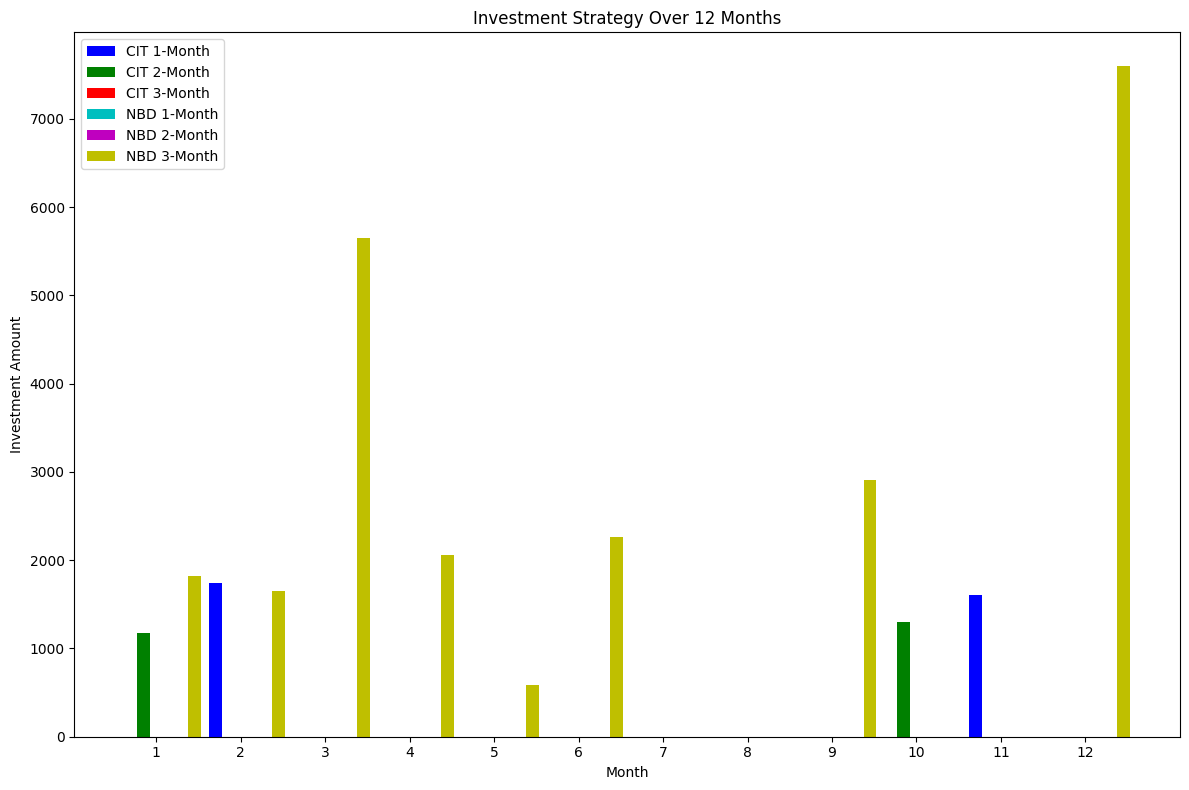

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Create lists for the months and investment amounts
months = list(range(1, 13))

# Get the investment amounts from the optimization results
CIT_investments_1M = [investments.loc[month, 'CIT1'].primal for month in months]
CIT_investments_2M = [investments.loc[month, 'CIT2'].primal for month in months]
CIT_investments_3M = [investments.loc[month, 'CIT3'].primal for month in months]
NBD_investments_1M = [investments.loc[month, 'NBD1'].primal for month in months]
NBD_investments_2M = [investments.loc[month, 'NBD2'].primal for month in months]
NBD_investments_3M = [investments.loc[month, 'NBD3'].primal for month in months]

# Create the bar plots
index = np.arange(len(months))
bar_width = 0.15

plt.figure(figsize=(12, 8))

plt.bar(index - 2*bar_width, CIT_investments_1M, bar_width, color='b', label='CIT 1-Month')
plt.bar(index - bar_width, CIT_investments_2M, bar_width, color='g', label='CIT 2-Month')
plt.bar(index, CIT_investments_3M, bar_width, color='r', label='CIT 3-Month')
plt.bar(index + bar_width, NBD_investments_1M, bar_width, color='c', label='NBD 1-Month')
plt.bar(index + 2*bar_width, NBD_investments_2M, bar_width, color='m', label='NBD 2-Month')
plt.bar(index + 3*bar_width, NBD_investments_3M, bar_width, color='y', label='NBD 3-Month')

plt.xlabel('Month')
plt.ylabel('Investment Amount')
plt.title('Investment Strategy Over 12 Months')
plt.xticks(index, months)
plt.legend()

plt.tight_layout()
plt.show()

# Company policy prohibits investing more than 70% of its cash in new certificates of any one bank in any month.**

In [42]:
# Create a model
model = Model(name='Investment Strategy Optimization')

# Create variables for the investments in each type of CD for each month
investments = pd.DataFrame({
    'CIT1': [Variable(f'Investment_{i}_CIT1', lb=0) for i in range(1, 13)],
    'CIT2': [Variable(f'Investment_{i}_CIT2', lb=0) for i in range(1, 13)],
    'CIT3': [Variable(f'Investment_{i}_CIT3', lb=0) for i in range(1, 13)],
    'NBD1': [Variable(f'Investment_{i}_NBD1', lb=0) for i in range(1, 13)],
    'NBD2': [Variable(f'Investment_{i}_NBD2', lb=0) for i in range(1, 13)],
    'NBD3': [Variable(f'Investment_{i}_NBD3', lb=0) for i in range(1, 13)]
}, index=range(1, 13))

# Add the investment variables to the model
for month in investments.index:
    for term in investments.columns:
        model.add(investments.loc[month, term])

# Create constraints for the cash flow for each month
for i in range(1, 13):
    model.add(Constraint(
        sum(investments.loc[i, term] for term in investments.columns) + receipts_expenses.loc[i, 'Expense'] - receipts_expenses.loc[i, 'Receipt'] - sum(investments.loc[i-j if i-j > 0 else None, term] * (1 + rates_of_return.loc[i-j if i-j > 0 else None, term]) for j in range(1, 4) for term in ['CIT'+str(j), 'NBD'+str(j)] if term in investments.columns and i-j > 0),
        ub=0,
        name=f'Cash_Flow_{i}'
    ))

# Create constraints for the company policy
for i in range(1, 13):
    total_cash = receipts_expenses.loc[i, 'Receipt'] - receipts_expenses.loc[i, 'Expense']
    model.add(Constraint(sum(investments.loc[i, term] for term in ['CIT1', 'CIT2', 'CIT3']), ub=0.7 * total_cash, name=f'Company_Policy_CIT_{i}'))
    model.add(Constraint(sum(investments.loc[i, term] for term in ['NBD1', 'NBD2', 'NBD3']), ub=0.7 * total_cash, name=f'Company_Policy_NBD_{i}'))

# Create the objective function
model.objective = Objective(
    sum(investments.loc[i, term] * rates_of_return.loc[i, term] for i in range(1, 13) for term in investments.columns),
    direction='max'
)

# Solve the problem
model.optimize()

# Display the solution
for month in range(1, 13):
    for term in investments.columns:
        print(f"Investment in {term} in Month {month}: {investments.loc[month, term].primal}")


Investment in CIT1 in Month 1: 13.225508729137257
Investment in CIT2 in Month 1: 722.3019585341503
Investment in CIT3 in Month 1: 0.0
Investment in NBD1 in Month 1: 0.0
Investment in NBD2 in Month 1: 0.0
Investment in NBD3 in Month 1: 78.42137766755218
Investment in CIT1 in Month 2: 0.0
Investment in CIT2 in Month 2: 0.0
Investment in CIT3 in Month 2: 1033.2827751819343
Investment in NBD1 in Month 2: 0.0
Investment in NBD2 in Month 2: 0.0
Investment in NBD3 in Month 2: 2380.0000000000005
Investment in CIT1 in Month 3: 0.0
Investment in CIT2 in Month 3: 0.0
Investment in CIT3 in Month 3: 1540.0089204317098
Investment in NBD1 in Month 3: 0.0
Investment in NBD2 in Month 3: 0.0
Investment in NBD3 in Month 3: 1889.9999999999998
Investment in CIT1 in Month 4: 0.0
Investment in CIT2 in Month 4: 0.0
Investment in CIT3 in Month 4: 140.0
Investment in NBD1 in Month 4: 0.0
Investment in NBD2 in Month 4: 0.0
Investment in NBD3 in Month 4: 140.0
Investment in CIT1 in Month 5: 0.0
Investment in CIT2

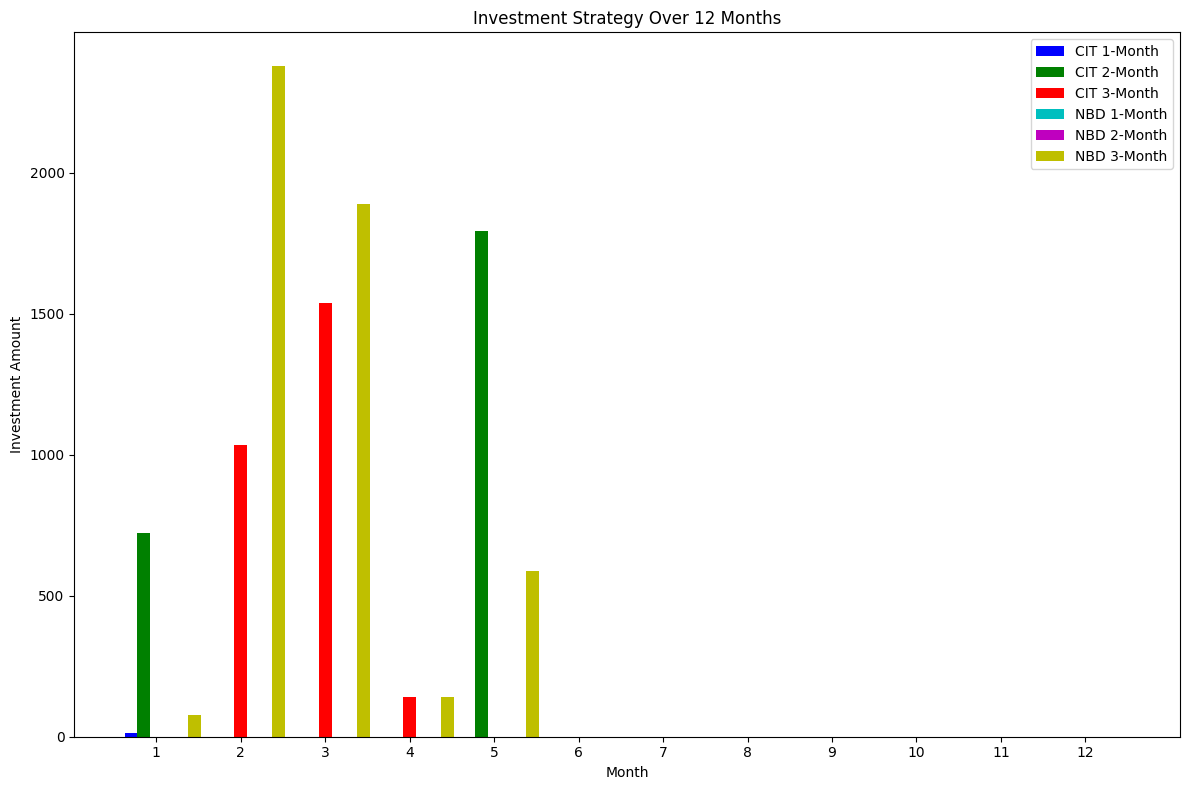

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Create lists for the months and investment amounts
months = list(range(1, 13))

# Get the investment amounts from the optimization results
CIT_investments_1M = [investments.loc[month, 'CIT1'].primal for month in months]
CIT_investments_2M = [investments.loc[month, 'CIT2'].primal for month in months]
CIT_investments_3M = [investments.loc[month, 'CIT3'].primal for month in months]
NBD_investments_1M = [investments.loc[month, 'NBD1'].primal for month in months]
NBD_investments_2M = [investments.loc[month, 'NBD2'].primal for month in months]
NBD_investments_3M = [investments.loc[month, 'NBD3'].primal for month in months]

# Create the bar plots
index = np.arange(len(months))
bar_width = 0.15

plt.figure(figsize=(12, 8))

plt.bar(index - 2*bar_width, CIT_investments_1M, bar_width, color='b', label='CIT 1-Month')
plt.bar(index - bar_width, CIT_investments_2M, bar_width, color='g', label='CIT 2-Month')
plt.bar(index, CIT_investments_3M, bar_width, color='r', label='CIT 3-Month')
plt.bar(index + bar_width, NBD_investments_1M, bar_width, color='c', label='NBD 1-Month')
plt.bar(index + 2*bar_width, NBD_investments_2M, bar_width, color='m', label='NBD 2-Month')
plt.bar(index + 3*bar_width, NBD_investments_3M, bar_width, color='y', label='NBD 3-Month')

plt.xlabel('Month')
plt.ylabel('Investment Amount')
plt.title('Investment Strategy Over 12 Months')
plt.xticks(index, months)
plt.legend()

plt.tight_layout()
plt.show()


#  **Modify the Markowitz model**

The optimization we sould like to solve is

\begin{align*}
\text{maximize} \quad & \mu^T x \\
\text{subject to} \quad & \text{CVaR}_\alpha (x) \leq 0 \\
& \sum_{i=1}^{N} x_i = 1 \\
& x_i \geq 0, \quad i = 1, ..., N
\end{align*}

where:

- `x` is the portfolio weights,
- `μ` is the expected returns,
- `CVaRα​(x)` is the Conditional Value at Risk at confidence level α
- `N` is the number of assets.

In [81]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm

# Data
mu = pd.Series([0.07197349, 0.15518171, 0.17535435, 0.0898094 , 0.42895777, 0.39291844, 0.32170722, 0.18378628])
Sigma = pd.DataFrame([
    [0.09460323, 0.03735969, 0.03488376, 0.03483838, 0.05420885, 0.03682539, 0.03209623, 0.03271886],
    [0.03735969, 0.07746293, 0.03868215, 0.03670678, 0.03816653, 0.03634422, 0.0356449, 0.03422235],
    [0.03488376, 0.03868215, 0.06241065, 0.03364444, 0.03949475, 0.03690811, 0.03383847, 0.02433733],
    [0.03483838, 0.03670678, 0.03364444, 0.06824955, 0.04017978, 0.03348263, 0.04360484, 0.03713089],
    [0.05420885, 0.03816653, 0.03949475, 0.04017978, 0.17243352, 0.07886889, 0.06999607, 0.05010711],
    [0.03682539, 0.03634422, 0.03690811, 0.03348263, 0.07886889, 0.09093307, 0.05364518, 0.04489357],
    [0.03209623, 0.0356449, 0.03383847, 0.04360484, 0.06999607, 0.05364518, 0.09649728, 0.04419974],
    [0.03271886, 0.03422235, 0.02433733, 0.03713009, 0.05010711, 0.04489357, 0.04419974, 0.08159633]
])

N = mu.shape[0]  # Number of securities
gamma2 = 0.05  # Risk limit

# Cholesky factor of S to use in conic risk constraint
G = np.linalg.cholesky(Sigma)

# Modify the Markowitz model such that the portfolio CVaR value less than or equal to zero**

In [90]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

# Define the objective function (negative because we want to maximize it)
def objective(weights):
    return -np.dot(mu, weights)

# Define the constraint for the CVaR
def cvar_constraint(weights, alpha):
    # Compute the portfolio returns
    portfolio_returns = np.dot(weights, mu)  # Use mu instead of returns
    # Compute the VaR at the confidence level alpha
    var = np.percentile(portfolio_returns, 100 * (1 - alpha))
    # Compute the CVaR as the mean of the returns that are less than the VaR
    cvar = portfolio_returns[portfolio_returns <= var].mean()
    return cvar



# Define the constraint for the budget
def budget_constraint(weights):
    return np.sum(weights) - 1

# Initial guess for the weights
x0 = np.repeat(1/N, N)

# Define the bounds
bounds = [(0,1) for _ in range(N)]

# Define the constraints
constraints = ({'type': 'eq', 'fun': budget_constraint},
               {'type': 'ineq', 'fun': lambda weights: cvar_constraint(weights, alpha)})

# Solve the optimization problem
optimal_portfolio = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)

# Check if the solution is an optimal point
if optimal_portfolio.success:
    print("Optimal weights:", optimal_portfolio.x)
else:
    print("Unexpected solution status:", optimal_portfolio.message)


Optimal weights: [0.00000000e+00 5.16010634e-16 0.00000000e+00 1.22605014e-16
 1.00000000e+00 0.00000000e+00 8.56093832e-16 3.54075806e-16]


# Solve your model with $\alpha$ equals 80%, 85%, 90%, 95%, 97%**

In [91]:
# List of alphas
alphas = [0.8, 0.85, 0.9, 0.95, 0.97]

# Initialize a DataFrame to store the optimal weights for each alpha
weights_df = pd.DataFrame()

for alpha in alphas:
    # Define the constraints
    constraints = ({'type': 'eq', 'fun': budget_constraint},
                   {'type': 'ineq', 'fun': lambda weights: cvar_constraint(weights, alpha)})

    # Solve the optimization problem
    optimal_portfolio = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)

    # Check if the solution is an optimal point
    if optimal_portfolio.success:
        # Add the optimal weights to the DataFrame
        weights_df[f'alpha={alpha}'] = optimal_portfolio.x
        print(f"Optimal weights for alpha={alpha}:", optimal_portfolio.x)
    else:
        print("Unexpected solution status:", optimal_portfolio.message)


Optimal weights for alpha=0.8: [0.00000000e+00 5.16010634e-16 0.00000000e+00 1.22605014e-16
 1.00000000e+00 0.00000000e+00 8.56093832e-16 3.54075806e-16]
Optimal weights for alpha=0.85: [0.00000000e+00 5.16010634e-16 0.00000000e+00 1.22605014e-16
 1.00000000e+00 0.00000000e+00 8.56093832e-16 3.54075806e-16]
Optimal weights for alpha=0.9: [0.00000000e+00 5.16010634e-16 0.00000000e+00 1.22605014e-16
 1.00000000e+00 0.00000000e+00 8.56093832e-16 3.54075806e-16]
Optimal weights for alpha=0.95: [0.00000000e+00 5.16010634e-16 0.00000000e+00 1.22605014e-16
 1.00000000e+00 0.00000000e+00 8.56093832e-16 3.54075806e-16]
Optimal weights for alpha=0.97: [0.00000000e+00 5.16010634e-16 0.00000000e+00 1.22605014e-16
 1.00000000e+00 0.00000000e+00 8.56093832e-16 3.54075806e-16]


# Interpret the optimal solution using DataFrame and plots.**

      alpha=0.8    alpha=0.85     alpha=0.9    alpha=0.95    alpha=0.97
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
1  5.160106e-16  5.160106e-16  5.160106e-16  5.160106e-16  5.160106e-16
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
3  1.226050e-16  1.226050e-16  1.226050e-16  1.226050e-16  1.226050e-16
4  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
5  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
6  8.560938e-16  8.560938e-16  8.560938e-16  8.560938e-16  8.560938e-16
7  3.540758e-16  3.540758e-16  3.540758e-16  3.540758e-16  3.540758e-16


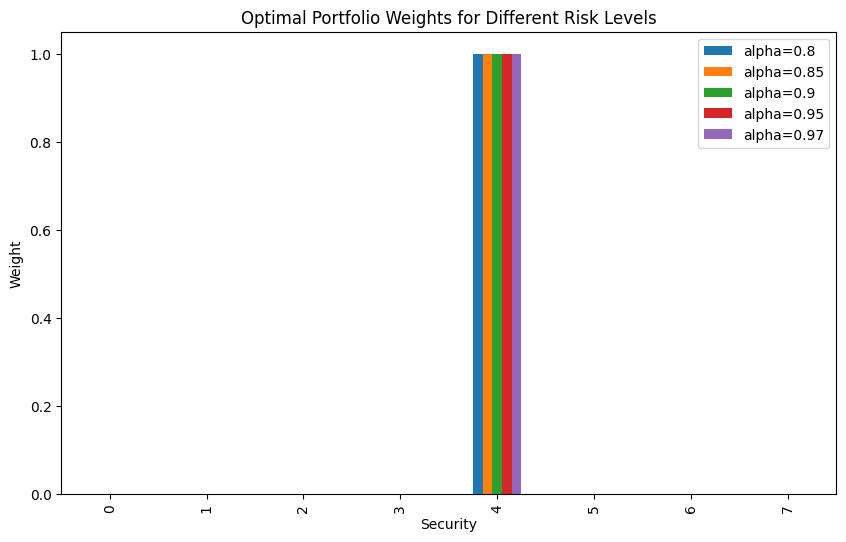

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

# List of alphas
alphas = [0.8, 0.85, 0.9, 0.95, 0.97]

# Initialize a DataFrame to store the optimal weights for each alpha
weights_df = pd.DataFrame()

for alpha in alphas:
    # Define the constraints
    constraints = ({'type': 'eq', 'fun': budget_constraint},
                   {'type': 'ineq', 'fun': lambda weights: risk_constraint(weights, alpha)})

    # Solve the optimization problem
    optimal_portfolio = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)

    # Check if the solution is an optimal point
    if optimal_portfolio.success:
        # Add the optimal weights to the DataFrame
        weights_df[f'alpha={alpha}'] = optimal_portfolio.x
    else:
        print("Unexpected solution status:", optimal_portfolio.message)

# Print the DataFrame
print(weights_df)

# Plot the optimal weights for each alpha
weights_df.plot(kind='bar', figsize=(10, 6))
plt.title('Optimal Portfolio Weights for Different Risk Levels')
plt.xlabel('Security')
plt.ylabel('Weight')
plt.show()


From the DataFrame, we can see that for all alpha values (80%, 85%, 90%, 95%, 97%), the optimal portfolio consists entirely of the 5th security (index 4), with a weight of 1. The weights of all other securities are essentially zero (or very close to zero due to numerical precision).

This suggests that the 5th security is the most desirable under the criteria of our optimization problem, which is to maximize the expected return subject to a CVaR constraint. The 5th security appears to offer the highest expected return for a given level of risk, as measured by the CVaR.

